In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# lightgbmでトレーニングする

In [16]:
# 必要なライブラリをインポート
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# データの読み込み
train_path = '/content/drive/My Drive/signate/train/train_proceed.csv'
train_data = pd.read_csv(train_path, low_memory=False, encoding="utf-8", dtype={'area_JIS_code': str, 'zip_code': str})

train_data = train_data.drop(columns=['land_toshi', 'target_quarter', 'madori_number_all', 'normalized_full_address',
                                      'snapshot_window_angle', 'land_kenpei', 'land_youseki', 'year_built_quarter'])

# 異常値の削除
# money_room が 1,000,000 より大きいデータを削除（上限値はデータに応じて調整）
train_data = train_data[train_data["money_room"] < 1e+06]

# ログ変換（必要に応じて）
train_data["log_money_room"] = np.log1p(train_data["money_room"])

# カテゴリ列の設定と変換
categorical_features = [
    'building_structure', 'land_youto', 'madori_kind_all',
    'normalized_addr2_name', 'normalized_eki_name1', 'area_JIS_code', 'zip_code'
]

for col in categorical_features:
    if col in train_data.columns:
        train_data[col] = train_data[col].astype('category')

# データの分割（分布を保つためにランダム分割を使用）
df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=42)

# 特徴量と目的変数の分割
train_y = df_train["log_money_room"]
train_x = df_train.drop(columns=["money_room", "log_money_room"])

val_y = df_val["log_money_room"]
val_x = df_val.drop(columns=["money_room", "log_money_room"])

# LightGBMデータセットに重みを追加
trains = lgb.Dataset(train_x, train_y, categorical_feature=categorical_features, free_raw_data=False)
valids = lgb.Dataset(val_x, val_y, categorical_feature=categorical_features, free_raw_data=False)

# ハイパーパラメータの設定
params = {
    "objective": "regression",
    "metric": "rmse",
    "num_leaves": 50,
    "max_depth": 8,
    "learning_rate": 0.01,
    "lambda_l1": 50.0,    # L1正則化を維持
    "lambda_l2": 50.0,
    "max_bin": 255,
    "force_row_wise": True,
    "verbosity": -1,
    "random_state": 42
}

# モデルのトレーニング
model = lgb.train(
    params,
    trains,
    valid_sets=[trains, valids],
    num_boost_round=5500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(50)
    ]
)

# 予測と評価
val_pred = model.predict(val_x, num_iteration=model.best_iteration)
val_pred_exp = np.expm1(val_pred)  # 逆対数変換
rmse_score = np.sqrt(mean_squared_error(df_val["money_room"], val_pred_exp))

#rmse_score = np.sqrt(mean_squared_error(df_val["money_room"], val_pred))
print(f"RMSE: {rmse_score}")



<ipython-input-16-e30d26c6a202>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["log_money_room"] = np.log1p(train_data["money_room"])
<ipython-input-16-e30d26c6a202>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[col] = train_data[col].astype('category')


Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.28654	valid_1's rmse: 0.28741
[100]	training's rmse: 0.224812	valid_1's rmse: 0.225769
[150]	training's rmse: 0.188673	valid_1's rmse: 0.189844
[200]	training's rmse: 0.167282	valid_1's rmse: 0.168715
[250]	training's rmse: 0.153912	valid_1's rmse: 0.155607
[300]	training's rmse: 0.145248	valid_1's rmse: 0.147176
[350]	training's rmse: 0.139484	valid_1's rmse: 0.14163
[400]	training's rmse: 0.135523	valid_1's rmse: 0.137888
[450]	training's rmse: 0.132658	valid_1's rmse: 0.135207
[500]	training's rmse: 0.130475	valid_1's rmse: 0.133209
[550]	training's rmse: 0.128745	valid_1's rmse: 0.131641
[600]	training's rmse: 0.127367	valid_1's rmse: 0.130407
[650]	training's rmse: 0.126221	valid_1's rmse: 0.129404
[700]	training's rmse: 0.125179	valid_1's rmse: 0.128501
[750]	training's rmse: 0.124307	valid_1's rmse: 0.127759
[800]	training's rmse: 0.123624	valid_1's rmse: 0.12719
[850]	training's rmse: 0.122946

In [9]:
import lightgbm as lgb

# モデルの保存
model_save_path = '/content/drive/My Drive/signate/models/lightgbm_model.txt'
model.save_model(model_save_path)

print(f"モデルが保存されました: {model_save_path}")


モデルが保存されました: /content/drive/My Drive/signate/models/lightgbm_model.txt


# 提出用ファイルの作成

In [14]:
import lightgbm as lgb
import pandas as pd
import numpy as np

# モデルの保存
model_save_path = '/content/drive/My Drive/signate/models/lightgbm_model.txt'
model.save_model(model_save_path)

# テストデータの読み込み
test_path = '/content/drive/My Drive/signate/test/test_proceed.csv'
test_data = pd.read_csv(test_path, low_memory=False, encoding="utf-8", dtype={'area_JIS_code': str, 'zip_code': str})

# 前処理（列の削除）
test_data = test_data.drop(columns=[
    'land_toshi', 'target_quarter', 'madori_number_all',
    'normalized_full_address', 'snapshot_window_angle',
    'land_kenpei', 'land_youseki', 'year_built_quarter', 'index'  # 必要に応じて削除
], errors='ignore')

# カテゴリ列の設定と変換
categorical_features = [
    'building_structure', 'land_youto', 'madori_kind_all',
    'normalized_addr2_name', 'normalized_eki_name1', 'area_JIS_code', 'zip_code'
]

for col in categorical_features:
    if col in test_data.columns:
        test_data[col] = test_data[col].astype('category')

# モデルの読み込み
model = lgb.Booster(model_file=model_save_path)

# 予測
test_predictions_log = model.predict(test_data, num_iteration=model.best_iteration)

# 逆対数変換を適用
test_predictions = np.expm1(test_predictions_log)

# 予測値を四捨五入して整数に変換
submission[1] = submission[1].round().astype(int)

# 修正したサブミッションファイルを保存
submission_path = '/content/drive/My Drive/signate/submissions/submission_1213_2.csv'
submission.to_csv(submission_path, index=False, header=False)

print(f"修正したサブミッションファイルが保存されました: {submission_path}")




サブミッションファイルが生成されました: /content/drive/My Drive/signate/submissions/submission_1213.csv


In [15]:
# 生成されたファイルの確認
submission = pd.read_csv(submission_path, header=None)
print(submission.head())


   0             1
0  0  63668.019352
1  1  50454.381020
2  2  59167.711393
3  3  46419.592080
4  4  84378.258901


# データの分布を確認する

In [ ]:
print("Training target distribution:")
print(train_y.describe())
print("Validation target distribution:")
print(val_y.describe())

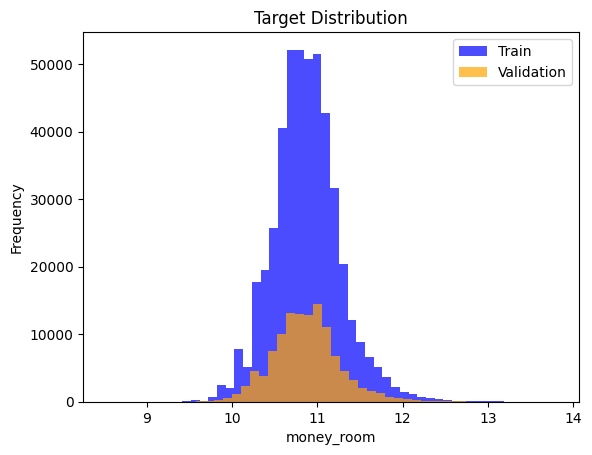

In [3]:
import matplotlib.pyplot as plt

plt.hist(train_y, bins=50, color='blue', alpha=0.7, label='Train')
plt.hist(val_y, bins=50, color='orange', alpha=0.7, label='Validation')
plt.legend()
plt.xlabel('money_room')
plt.ylabel('Frequency')
plt.title('Target Distribution')
plt.show()


# モデルが重視する特徴量を可視化する

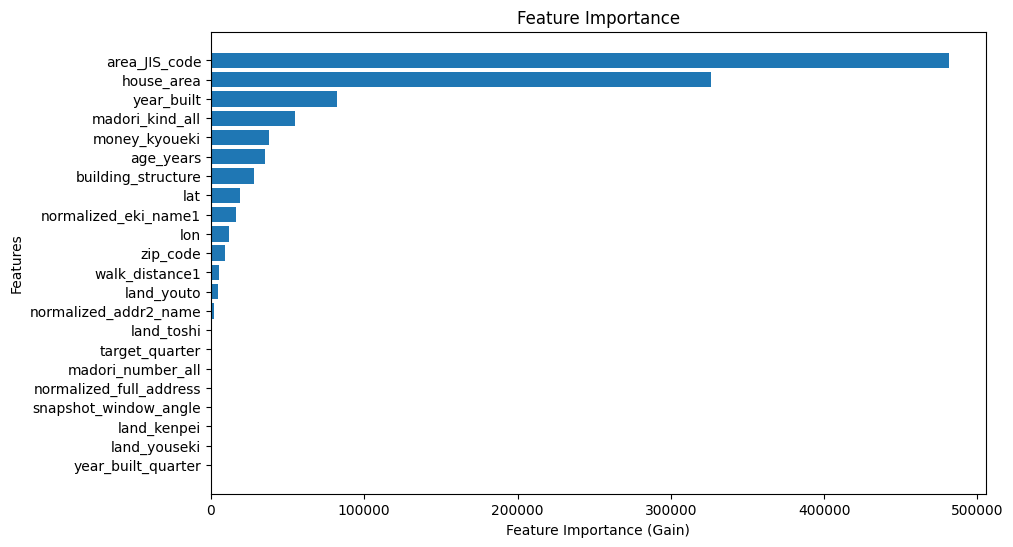

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 特徴量重要度を取得
feature_importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# 特徴量と重要度をデータフレームにまとめる
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 重要度でソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 棒グラフで可視化
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 特徴量を上から下に並べる
plt.show()

In [ ]:
# トレーニングデータの数
print(f"Training data size: {train_x.shape[0]} samples")

# 検証データの数
print(f"Validation data size: {val_x.shape[0]} samples")